Bibliotecas utilizadas

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.7 MB/s 


In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

Import das bases de dados

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
stores = pd.read_csv('/content/sample_data/stores.csv')
features = pd.read_csv('/content/sample_data/features.csv')

#1 - Análise e Tratamento dos Dados

Analisando o conjunto de dados "Train"

In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Percebemos que os valores das datas estão como object

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


Para podermos realizar analises em cima das datas vamos transforma-las para o formato de DateTime

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

Conseguimos saber qual o intervalo temporal nossa base se encontra

In [ ]:
train['Date'].max()

Timestamp('2012-10-26 00:00:00')

In [ ]:
train['Date'].min()

Timestamp('2010-02-05 00:00:00')

In [ ]:
train.shape

(421570, 5)

Agora vamos avaliar nosso conjunto "Stores"

In [ ]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
stores.shape

(45, 3)

Percebemos que estamos trabalhando com 45 lojas diferentes

In [ ]:
stores['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

E com 3 tipos de loja

Agora analisando nosso conjunto de dado de "Features"

In [ ]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Percebemos que alguns registros como os de MarkDown, CPI e Unemployment apresentam alguns valores nulos. Vamos realizar algumas analises para entender se o periodo em que esses valores se encontram pertencem tambem a nossa base "Train"

In [ ]:
features.isnull().sum()/features.shape[0]

Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.507692
MarkDown2       0.643346
MarkDown3       0.558852
MarkDown4       0.577045
MarkDown5       0.505495
CPI             0.071429
Unemployment    0.071429
IsHoliday       0.000000
dtype: float64

In [ ]:
features['Date'] = pd.to_datetime(features['Date'])

Vamos filtrar o dataset feature para pegar só os valores correspondentes as datas de registro do dataset train

In [ ]:
f_filtrado = features[features['Date'] <= train['Date'].max()]

In [ ]:
f_filtrado.isnull().sum()/f_filtrado.shape[0]

Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.645688
MarkDown2       0.745610
MarkDown3       0.682051
MarkDown4       0.694639
MarkDown5       0.643357
CPI             0.000000
Unemployment    0.000000
IsHoliday       0.000000
dtype: float64

Com esse filtro percebemos que acabamos tratando os valores nulos nas features CPI e Unemployment

Como os valores nulos nas colunas de MarkDown significam que não ocorreu promoção, vamos completar os valores nulos por 0

In [ ]:
f_filtrado.fillna(0, inplace=True)

In [ ]:
f_filtrado.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

Com os dados tratados vamos unir os dataframes de train com o de features usando como referencia as colunas Store, Date e IsHoliday

In [ ]:
intermediario = train.merge(f_filtrado, how='left', on=['Store', 'Date', 'IsHoliday'])

In [ ]:
intermediario.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


E vamos realizar o mesmo procedimento para integrar o dataset Stores ao dataset intermediario criado. Esse junção será feita usando como referencia o conjunto de dados Store

In [ ]:
merge = intermediario.merge(stores, how='left', on=['Store'])

In [ ]:
merge.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


Percebemos que algumas variaveis precisam passar pelo processo de dummificação, inclusive uma variavel que ja se apresenta como númerica: Store. Essa variavel será transformada em novas categorias por conta da interpretação do modelo.

In [ ]:
merge['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [ ]:
merge['IsHoliday'].unique()

array([False,  True])

In [ ]:
merge['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
df_merge = pd.get_dummies(merge, columns=['Type',	'IsHoliday', 'Store', 'Dept'])

In [ ]:
df_merge.shape

(421570, 143)

In [ ]:
df_merge.head()

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Columns: 143 entries, Date to Dept_99
dtypes: datetime64[ns](1), float64(10), int64(1), uint8(131)
memory usage: 94.5 MB


#2 - Análise Micro 

Vamos selecionar uma amostra de 1000 registros, escolhidos de forma aleatoria

In [ ]:
amostra = df_merge.sample(n=1000, random_state=5)

In [ ]:
amostra.head()

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
138040,2012-02-17,21376.88,36.85,3.695,23664.75,13769.67,143.36,11965.7,10506.12,189.842483,...,0,0,0,0,0,0,0,0,1,0
121240,2011-09-23,2020.91,63.60,3.648,0.00,0.00,0.00,0.0,0.00,129.518333,...,0,0,0,0,0,0,0,0,0,0
180231,2011-04-08,4372.62,41.26,3.895,0.00,0.00,0.00,0.0,0.00,134.177774,...,0,0,0,0,0,0,0,0,0,0
272846,2011-05-27,15.94,76.67,4.087,0.00,0.00,0.00,0.0,0.00,129.062355,...,0,0,0,0,0,0,0,0,0,0
211817,2010-12-24,5261.00,29.76,3.150,0.00,0.00,0.00,0.0,0.00,136.597273,...,0,0,0,0,0,0,0,0,0,0


Separando as variaveis entre variaveis dependentes (Y) e variaveis independentes (X)

In [ ]:
X = amostra.drop(columns=['Weekly_Sales', 'Date'])
Y = amostra['Weekly_Sales']

Realizando a separação entre a massa de treino e a de teste em 80 e 20% respectivamente

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=5)

Para melhorar a performance dos modelos vamos padronizar os dados não categoricos

In [ ]:
scaler = StandardScaler()
colunas_scaler =['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
                 'MarkDown4','MarkDown5','CPI','Unemployment','Size']

In [ ]:
scaler.fit(Xtrain[colunas_scaler]) 

StandardScaler()

In [ ]:
Xtrain = Xtrain.reset_index().drop('index',axis=1)
Xtest = Xtest.reset_index().drop('index',axis=1)
ytrain = ytrain.reset_index().drop('index',axis=1)
ytest = ytest.reset_index().drop('index',axis=1)

Xtrain[colunas_scaler] = pd.DataFrame(scaler.transform(Xtrain[colunas_scaler]),columns=colunas_scaler)
Xtrain.head() 

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,0.793133,-1.217749,-0.413492,-0.177759,-0.084439,-0.269288,-0.398254,-0.945569,-1.424451,0.270290,...,0,0,0,0,0,0,0,0,0,0
1,0.462458,0.561317,-0.413492,-0.177759,-0.084439,-0.269288,-0.398254,-1.021540,-0.767771,-1.599182,...,0,0,0,0,0,0,0,0,0,0
2,-1.429649,-0.522902,0.366803,9.757930,-0.063591,-0.021070,0.143448,0.691312,-0.661872,0.939660,...,0,0,0,0,0,0,0,0,0,0
3,0.744390,0.548410,0.423724,-0.177759,-0.080114,0.141772,0.854725,1.470403,-1.047685,1.121100,...,0,0,0,0,0,0,0,0,0,0
4,-0.704600,0.653820,0.303483,-0.155290,0.163382,1.136952,4.172143,-0.844876,0.240132,1.061366,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Xtest[colunas_scaler] = pd.DataFrame(scaler.transform(Xtest[colunas_scaler]),columns=colunas_scaler)

Vamos realizar a seleção dos modelos utilizando os hiperparametros default de cada um, usando as metricas r2, Mean Absolute Error (MAE) e Mean Squared Error (MSE).

In [ ]:
modelos = [
           ['Linear Regression',LinearRegression()],
           ['SGDRegressor',SGDRegressor()],
           ['GradientBoostingRegressor',GradientBoostingRegressor()],
           ['ExtraTreesRegressor',ExtraTreesRegressor()],
           ['RandomForestRegressor',RandomForestRegressor()],
           ['HuberReg',HuberRegressor()]
]

In [ ]:
for nome, modelo in modelos:
  print(50*'-')
  modelo.fit(Xtrain, ytrain)
  ypred = modelo.predict(Xtest)
  print(f'Modelo:{nome}')
  print(f'R2: {r2_score(ytest, ypred)}')
  print(f'MAE: {mean_absolute_error(ytest, ypred)}')
  print(f'MSE: {mean_squared_error(ytest, ypred)}')

--------------------------------------------------
Modelo:Linear Regression
R2: 0.45819241337292693
MAE: 9749.70935
MSE: 267823110.31311953
--------------------------------------------------
Modelo:SGDRegressor
R2: 0.4639614063048447
MAE: 9651.092953707208
MSE: 264971415.96897206
--------------------------------------------------
Modelo:GradientBoostingRegressor
R2: 0.4143105659720274
MAE: 9068.704536168521
MSE: 289514524.658862
--------------------------------------------------
Modelo:ExtraTreesRegressor
R2: 0.5134444655613575
MAE: 6081.411395500001
MSE: 240511243.82485348
--------------------------------------------------
Modelo:RandomForestRegressor
R2: 0.5899540069614178
MAE: 7146.4755225
MSE: 202691501.4436924
--------------------------------------------------
Modelo:HuberReg
R2: 0.43876250212833345
MAE: 7966.842068773068
MSE: 277427588.7129701


O modelo que escolhemos para seguir a analise será o ExtraTreesRegressor

In [ ]:
parametros = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth':[5, 7, 10],
    'warm_start': [True, False]
    }

bootstrap -> True or False: Se usa o dataset todo ou uma amostra das colunas e linhas

Multicolinearidade - > ?

In [ ]:
opt = BayesSearchCV(ExtraTreesRegressor(), parametros, random_state=0)
opt.fit(Xtrain, ytrain)

BayesSearchCV(estimator=ExtraTreesRegressor(), random_state=0,
              search_spaces={'criterion': ['squared_error', 'absolute_error'],
                             'max_depth': [5, 7, 10],
                             'n_estimators': [50, 100, 200],
                             'warm_start': [True, False]})

In [ ]:
opt.best_params_

OrderedDict([('criterion', 'squared_error'),
             ('max_depth', 10),
             ('n_estimators', 50),
             ('warm_start', False)])

In [ ]:
est = opt.best_estimator_
ypred = est.predict(Xtest)
print(f'R2: {r2_score(ytest, ypred)}')
print(f'MAE: {mean_absolute_error(ytest, ypred)}')
print(f'MSE: {mean_squared_error(ytest, ypred)}')

R2: 0.36046222777905657
MAE: 9660.217257816337
MSE: 316132515.5766613


#3 - Massa Total

Agora vamos realizar a predição para a massa de dados Total

In [ ]:
scaler = StandardScaler()
colunas_scaler =['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
                 'MarkDown4','MarkDown5','CPI','Unemployment','Size']

Dividindo os dados entre as variaveis dependentes e Independentes

In [ ]:
X = df_merge.drop(columns=['Weekly_Sales'])
Y = df_merge['Weekly_Sales']

Padronizando os dados para melhorar a performance do modelo escolhido

In [ ]:
scaler.fit(X[colunas_scaler])
X[colunas_scaler] = pd.DataFrame(scaler.transform(X[colunas_scaler]),columns=colunas_scaler)

Usando o estimador com os parametros otimizados vamos predizer os valores de faturamento semanal

In [ ]:
Ypred = est.predict(X.drop(columns=['Date']))

Comparando os dados preditos dos dados real

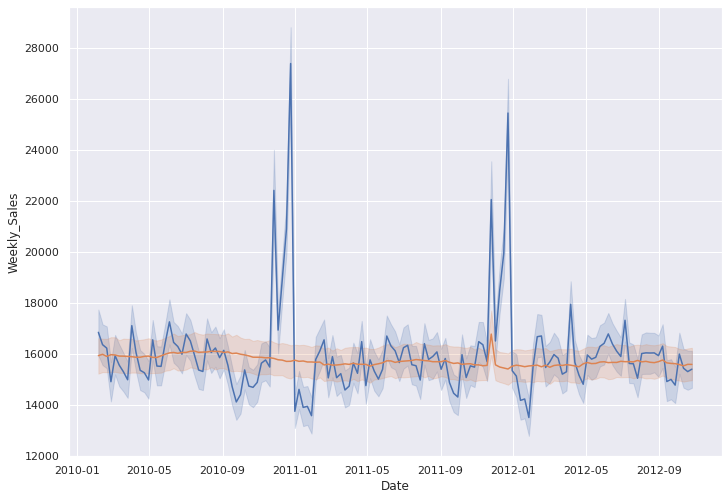

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=X['Date'], y=Y)
sns.lineplot(x=X['Date'], y=Ypred)
plt.show()